In [ ]:
!pip install fbm --quiet

In [ ]:
import numpy as np
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt

from fbm import FBM

np.random.seed(42)

In [ ]:
pkn = yf.Ticker("pkn.wa")

pkn_hist = pkn.history(start="2000-01-01", end="2024-03-01", interval="1d")

prices = pkn_hist['Close'].values
prices_log = np.log10(prices)

# Logarytmiczne stopy zwrotu
log_return_rates = np.diff(prices_log)

# Normalizacja
mean = np.mean(log_return_rates)
std = np.std(log_return_rates)
log_return_rates_norm = (log_return_rates - mean) / std

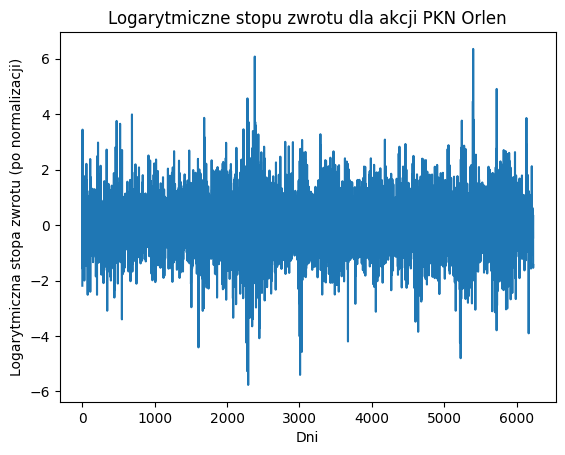

In [ ]:
# Wykres
plt.plot(log_return_rates_norm)
plt.title('Logarytmiczne stopu zwrotu dla akcji PKN Orlen')
plt.ylabel('Logarytmiczna stopa zwrotu (po normalizacji)')
plt.xlabel('Dni')
plt.show()

### Generowanie danych białego szumu

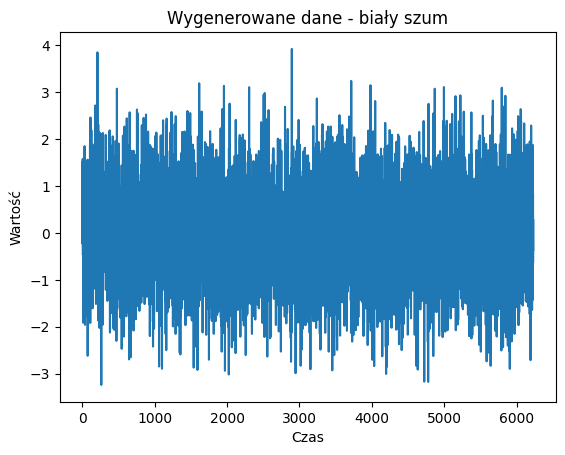

In [ ]:
# Generowanie danych o rozkładzie normalnym
white_noise = np.random.normal(0, 1, len(log_return_rates_norm))

# Wykres
plt.plot(white_noise)
plt.title('Wygenerowane dane - biały szum')
plt.ylabel('Wartość')
plt.xlabel('Czas')
plt.show()

### Generowanie danych ułamkowego ruchu Browna

In [ ]:
# Generowanie danych fbm dla wartości H 0.25 i 0.75
f_025 = FBM(len(log_return_rates), 0.25)
f_075 = FBM(len(log_return_rates), 0.75)

f_025_sample = np.diff(f_025.fbm())
f_075_sample = np.diff(f_075.fbm())

f_025_norm = (f_025_sample - np.mean(f_025_sample)) / np.std(f_025_sample)
f_075_norm = (f_075_sample - np.mean(f_075_sample)) / np.std(f_075_sample)

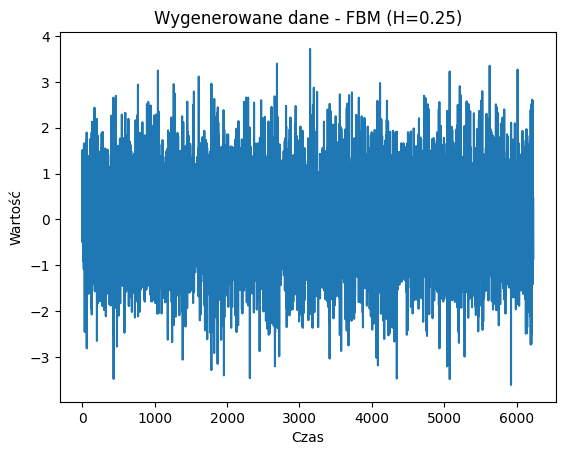

In [ ]:
# Wykres
plt.plot(f_025_norm)
plt.title('Wygenerowane dane - FBM (H=0.25)')
plt.ylabel('Wartość')
plt.xlabel('Czas')
plt.show()

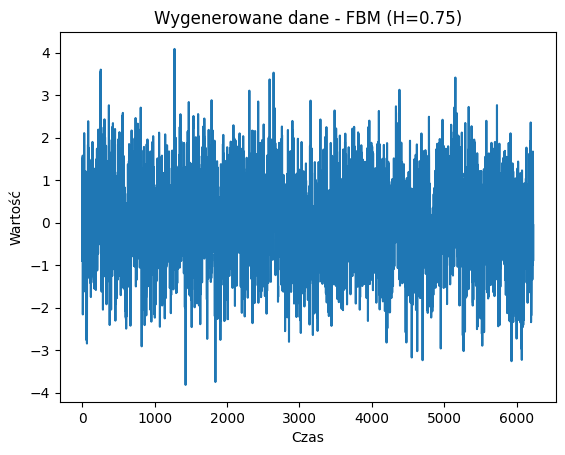

In [ ]:
# Wykres
plt.plot(f_075_norm)
plt.title('Wygenerowane dane - FBM (H=0.75)')
plt.ylabel('Wartość')
plt.xlabel('Czas')
plt.show()

### Zdefiniowanie funkcji autokorelacji

In [ ]:
def autocorrelation(signal, max_tau):
    signal = np.asarray(signal)
    sum_max = np.sum(signal ** 2)

    taus = np.arange(1, max_tau + 1)
    res = np.array([np.sum(signal[tau:] * signal[:-tau]) for tau in taus]) / sum_max

    return np.append([1], res)

### Policzenie funkcji autokorelacji

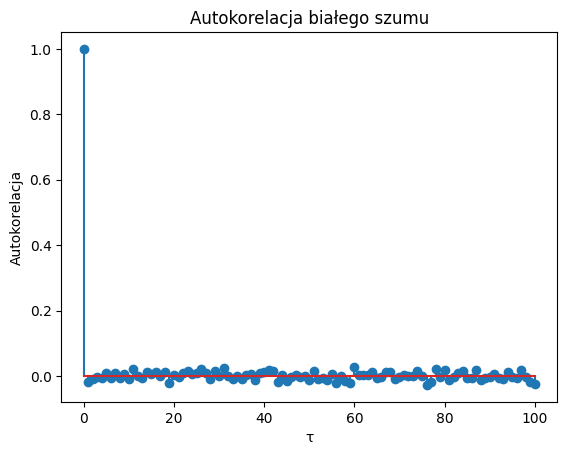

In [ ]:
plt.stem(autocorrelation(white_noise, 100))
plt.title('Autokorelacja białego szumu')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

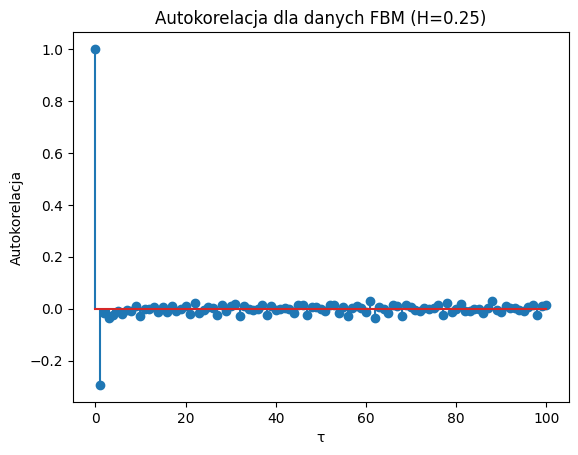

In [ ]:
plt.stem(autocorrelation(f_025_norm, 100))
plt.title('Autokorelacja dla danych FBM (H=0.25)')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

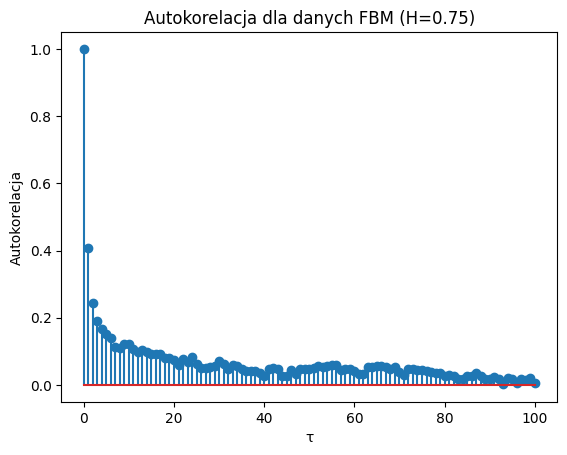

In [ ]:
plt.stem(autocorrelation(f_075_norm, 100))
plt.title('Autokorelacja dla danych FBM (H=0.75)')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

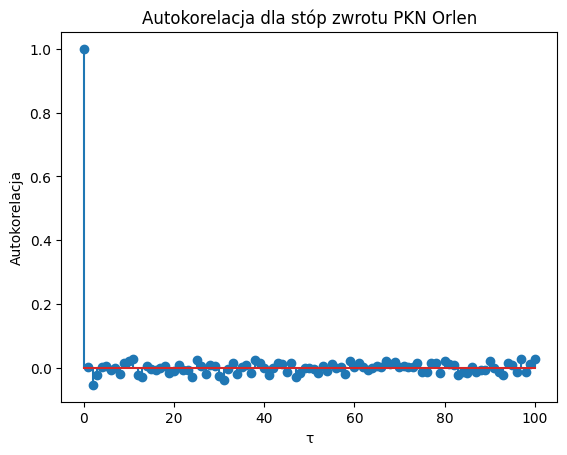

In [ ]:
plt.stem(autocorrelation(log_return_rates_norm, 100))
plt.title('Autokorelacja dla stóp zwrotu PKN Orlen')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

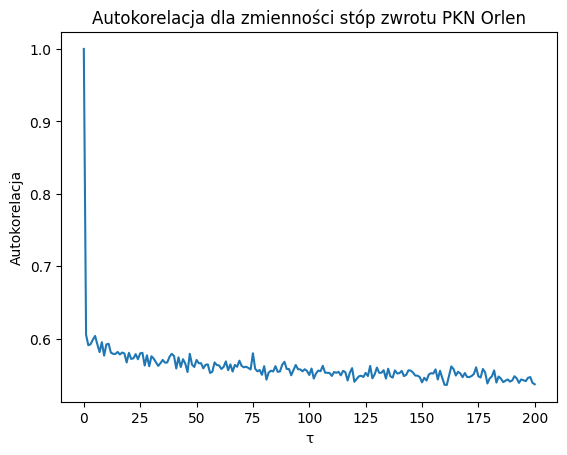

In [ ]:
plt.plot(autocorrelation(np.abs(log_return_rates_norm), 200))
plt.title('Autokorelacja dla zmienności stóp zwrotu PKN Orlen')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

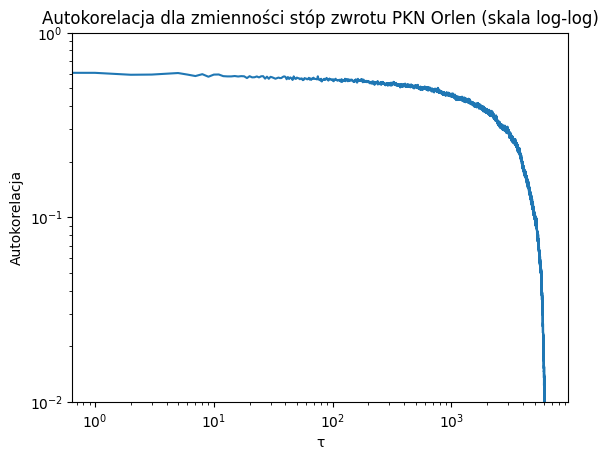

In [ ]:
plt.plot(autocorrelation(np.abs(log_return_rates_norm), len(log_return_rates_norm)-1))
plt.title('Autokorelacja dla zmienności stóp zwrotu PKN Orlen (skala log-log)')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2, 1])
plt.show()

### Transformata Fouriera

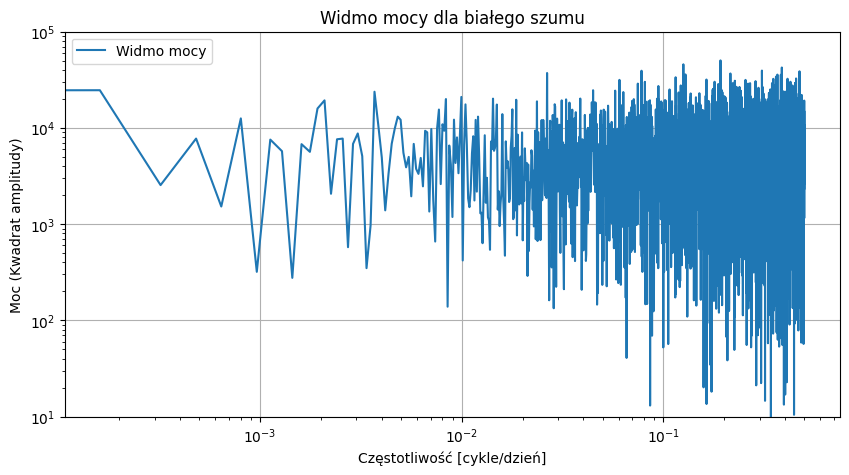

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(white_noise)
fft_frequencies = np.fft.fftfreq(len(white_noise), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla białego szumu')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.ylim([1e1, 1e5])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

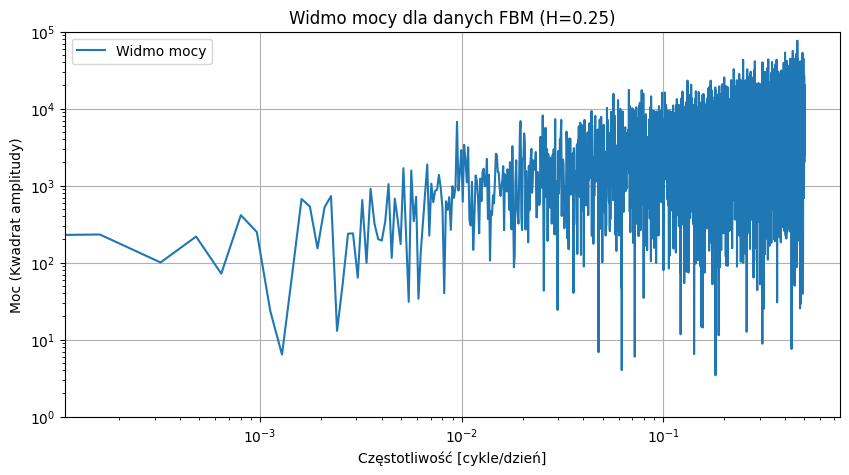

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(f_025_norm)
fft_frequencies = np.fft.fftfreq(len(f_025_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla danych FBM (H=0.25)')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.ylim([1, 1e5])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

Wykładnik -beta: 0.5764872226391018


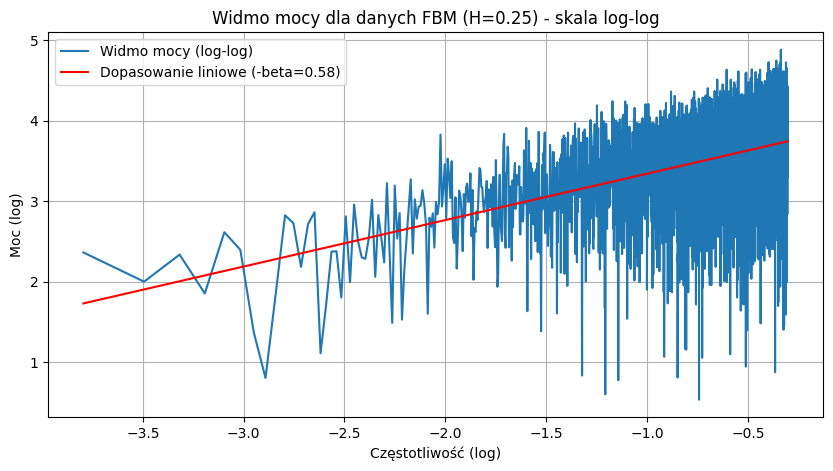

In [ ]:
fft_frequencies = fft_frequencies
power_spectrum = np.abs(fft_white_noise)**2

log_frequencies = np.log10(fft_frequencies[fft_frequencies > 0])
log_power_spectrum = np.log10(power_spectrum[fft_frequencies > 0])

slope, intercept, r_value, p_value, std_err = stats.linregress(log_frequencies, log_power_spectrum)
print(f"Wykładnik -beta: {slope}")

plt.figure(figsize=(10, 5))
plt.plot(log_frequencies, log_power_spectrum, label="Widmo mocy (log-log)")
plt.plot(log_frequencies, slope * log_frequencies + intercept, label=f"Dopasowanie liniowe (-beta={slope:.2f})", color='red')
plt.title('Widmo mocy dla danych FBM (H=0.25) - skala log-log')
plt.ylabel('Moc (log)')
plt.xlabel('Częstotliwość (log)')
plt.grid()
plt.legend()
plt.show()

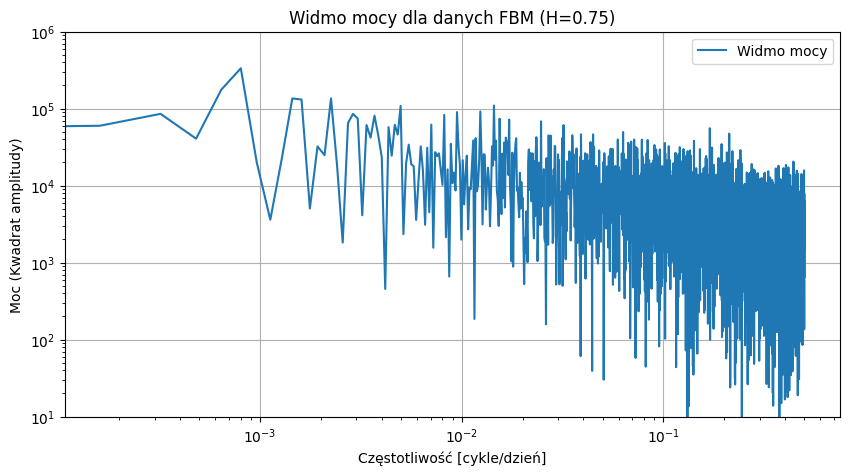

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(f_075_norm)
fft_frequencies = np.fft.fftfreq(len(f_075_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla danych FBM (H=0.75)')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.ylim([1e1, 1e6])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

Wykładnik -beta: -0.5384764021616568


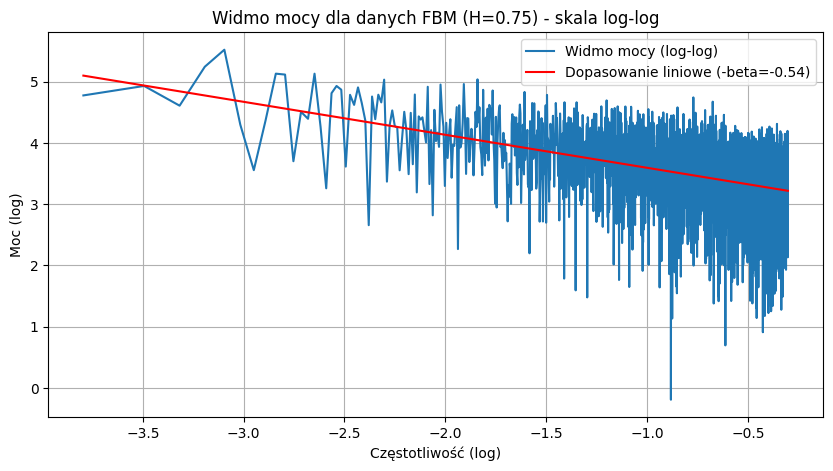

In [ ]:
fft_frequencies = fft_frequencies
power_spectrum = np.abs(fft_white_noise)**2

log_frequencies = np.log10(fft_frequencies[fft_frequencies > 0])
log_power_spectrum = np.log10(power_spectrum[fft_frequencies > 0])

slope, intercept, r_value, p_value, std_err = stats.linregress(log_frequencies, log_power_spectrum)
print(f"Wykładnik -beta: {slope}")

plt.figure(figsize=(10, 5))
plt.plot(log_frequencies, log_power_spectrum, label="Widmo mocy (log-log)")
plt.plot(log_frequencies, slope * log_frequencies + intercept, label=f"Dopasowanie liniowe (-beta={slope:.2f})", color='red')
plt.title('Widmo mocy dla danych FBM (H=0.75) - skala log-log')
plt.ylabel('Moc (log)')
plt.xlabel('Częstotliwość (log)')
plt.grid()
plt.legend()
plt.show()

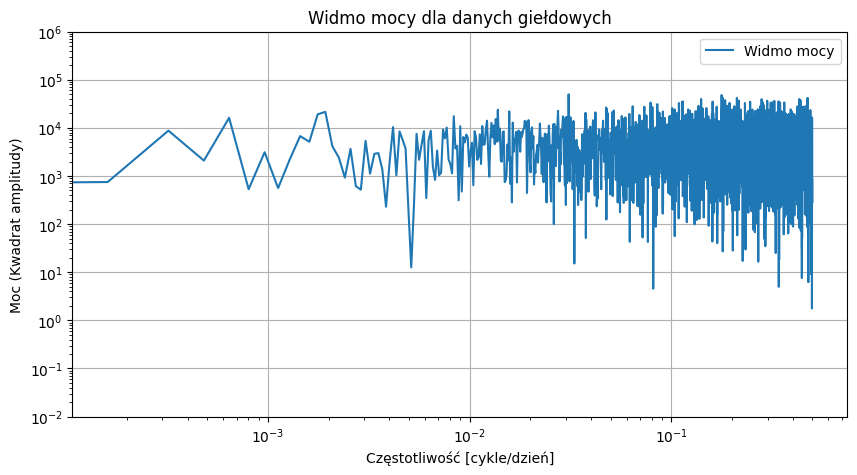

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(log_return_rates_norm)
fft_frequencies = np.fft.fftfreq(len(log_return_rates_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla danych giełdowych')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-2, 1e6])
plt.grid()
plt.legend()
plt.show()

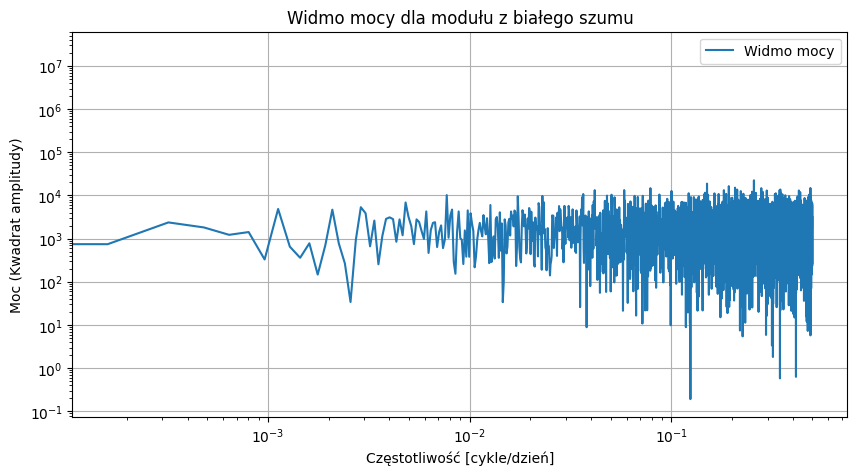

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(np.abs(white_noise))
fft_frequencies = np.fft.fftfreq(len(white_noise), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla modułu z białego szumu')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

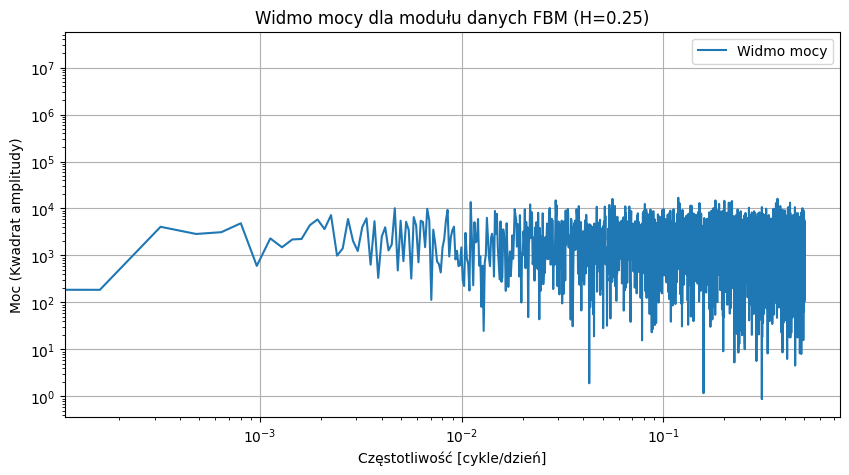

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(np.abs(f_025_norm))
fft_frequencies = np.fft.fftfreq(len(f_025_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla modułu danych FBM (H=0.25)')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

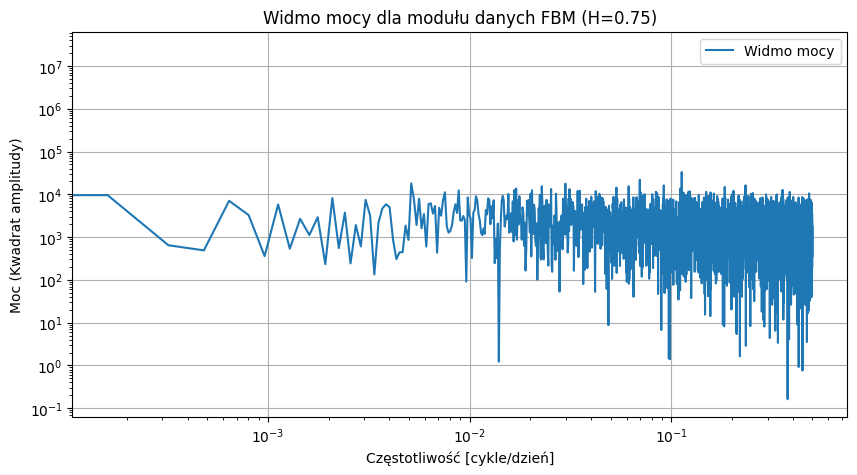

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(np.abs(f_075_norm))
fft_frequencies = np.fft.fftfreq(len(f_075_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla modułu danych FBM (H=0.75)')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

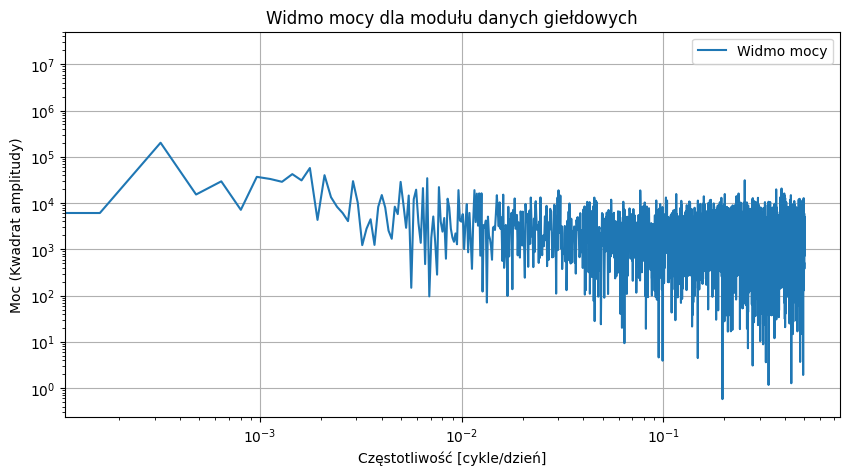

In [ ]:
# Obliczenie transformaty Fouriera
fft_white_noise = np.fft.fft(np.abs(log_return_rates_norm))
fft_frequencies = np.fft.fftfreq(len(log_return_rates_norm), d=1)

fft_frequencies = np.fft.fftshift(fft_frequencies)
fft_white_noise = np.fft.fftshift(fft_white_noise)

# Wizualizacja widma mocy
plt.figure(figsize=(10, 5))
plt.plot(fft_frequencies, np.abs(fft_white_noise)**2, label="Widmo mocy")
plt.title('Widmo mocy dla modułu danych giełdowych')
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość [cykle/dzień]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

<ipython-input-97-20da8da0580d>:9: RuntimeWarning: divide by zero encountered in power
  power_spectrum = frequencies ** -0.5


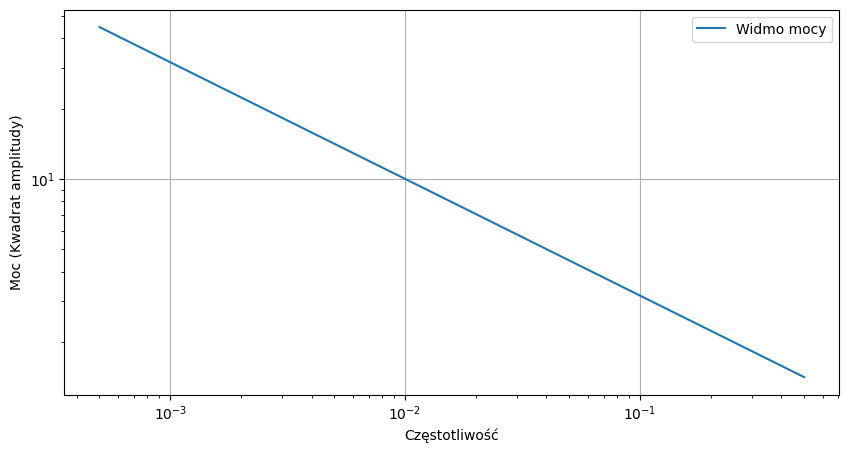

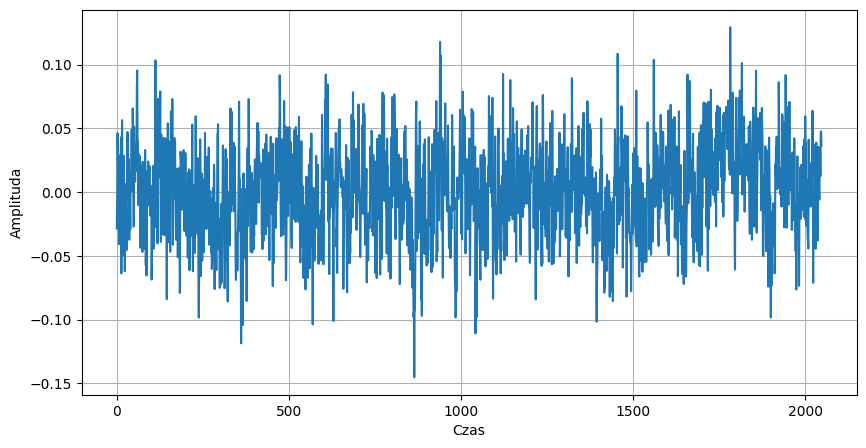

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# frequencies = np.linspace(0.0, 0.5, 1000)
# noise_level = 0.2
# power_spectrum = frequencies ** 0.5 + np.random.uniform(-noise_level, noise_level, len(frequencies))
# power_spectrum = np.maximum(power_spectrum, 0)
frequencies = np.linspace(0.0, 0.5, 1000)
power_spectrum = frequencies ** -0.5

# Wyznaczanie amplitud i losowych faz
amplitudes = np.sqrt(power_spectrum)
phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(frequencies)))
complex_spectrum = amplitudes * phases

# Uzupełnienie do pełnej długości dla FFT
n = int(np.ceil(np.log2(len(frequencies))))
new_size = 2**(n+1)
half_size = len(frequencies)

# Tworzenie symetrycznego widma
full_spectrum = np.zeros(new_size, dtype=np.complex128)
full_spectrum[1:half_size] = complex_spectrum[1:]
full_spectrum[-half_size+1:] = np.conj(complex_spectrum[1:][::-1])

# Odwrotna transformata Fouriera do dziedziny czasu
reconstructed_signal = np.fft.ifft(full_spectrum).real

# Rysowanie widma mocy
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(complex_spectrum)**2, label="Widmo mocy")
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Rysowanie sygnału w dziedzinie czasu
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, label="sygnał")
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.grid()
plt.show()


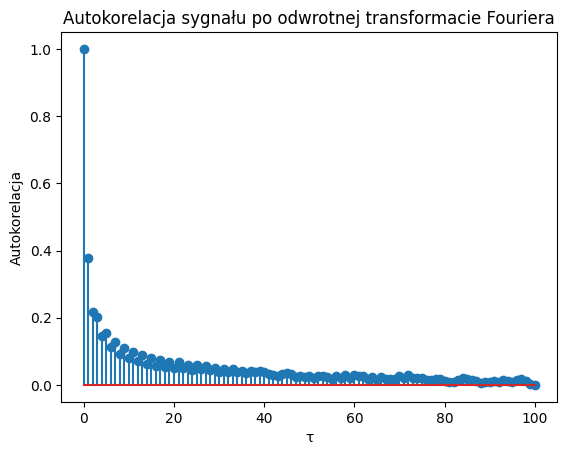

In [ ]:
plt.stem(autocorrelation(reconstructed_signal, 100))
plt.title('Autokorelacja sygnału po odwrotnej transformacie Fouriera')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

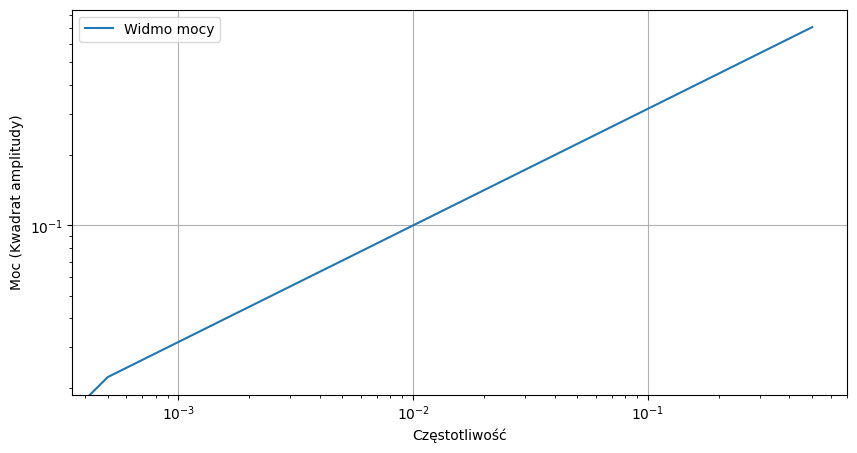

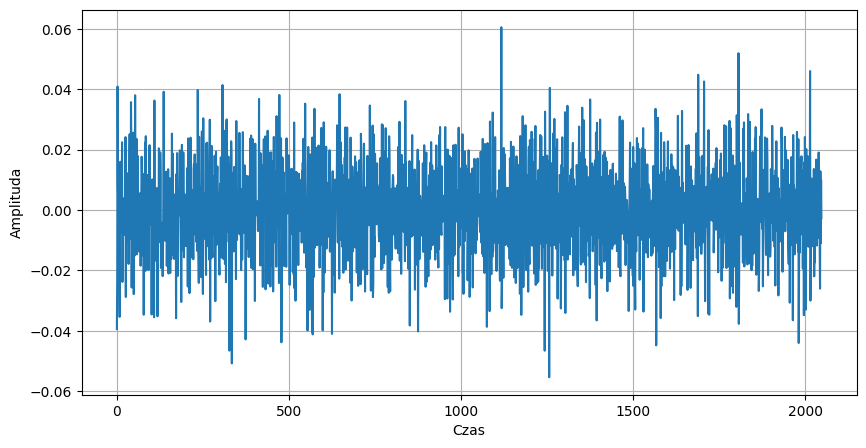

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# frequencies = np.linspace(0.0, 0.5, 1000)
# noise_level = 0.2
# power_spectrum = frequencies ** 0.5 + np.random.uniform(-noise_level, noise_level, len(frequencies))
# power_spectrum = np.maximum(power_spectrum, 0)
frequencies = np.linspace(0.0, 0.5, 1000)
power_spectrum = frequencies ** 0.5

# Wyznaczanie amplitud i losowych faz
amplitudes = np.sqrt(power_spectrum)
phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(frequencies)))
complex_spectrum = amplitudes * phases

# Uzupełnienie do pełnej długości dla FFT
n = int(np.ceil(np.log2(len(frequencies))))
new_size = 2**(n+1)
half_size = len(frequencies)

# Tworzenie symetrycznego widma
full_spectrum = np.zeros(new_size, dtype=np.complex128)
full_spectrum[1:half_size] = complex_spectrum[1:]
full_spectrum[-half_size+1:] = np.conj(complex_spectrum[1:][::-1])

# Odwrotna transformata Fouriera do dziedziny czasu
reconstructed_signal = np.fft.ifft(full_spectrum).real

# Rysowanie widma mocy
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(complex_spectrum)**2, label="Widmo mocy")
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Rysowanie sygnału w dziedzinie czasu
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, label="sygnał")
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.grid()
plt.show()


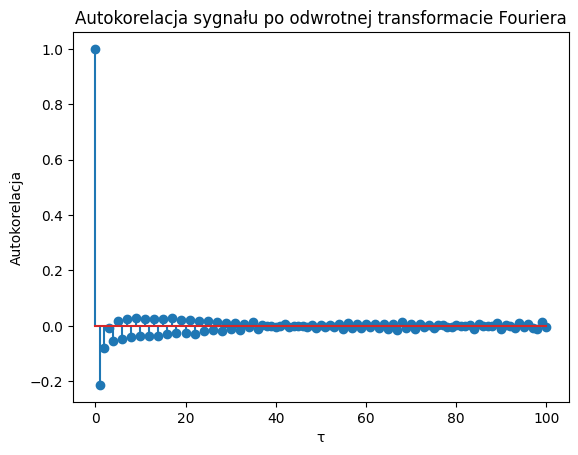

In [ ]:
plt.stem(autocorrelation(reconstructed_signal, 100))
plt.title('Autokorelacja sygnału po odwrotnej transformacie Fouriera')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

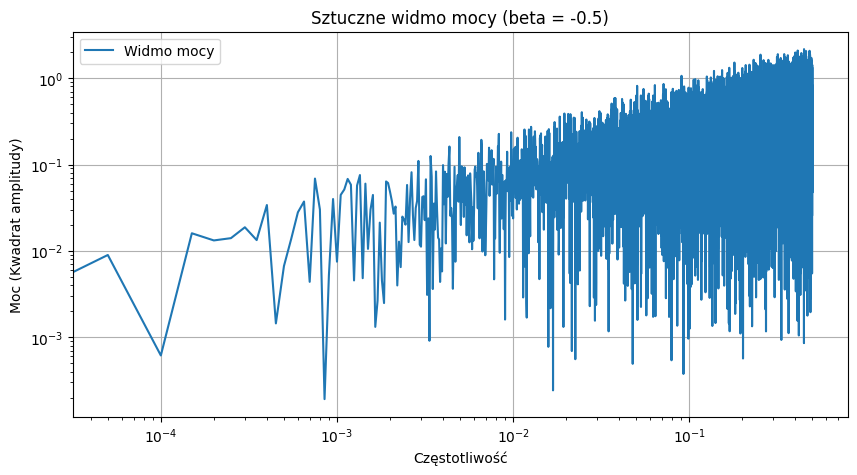

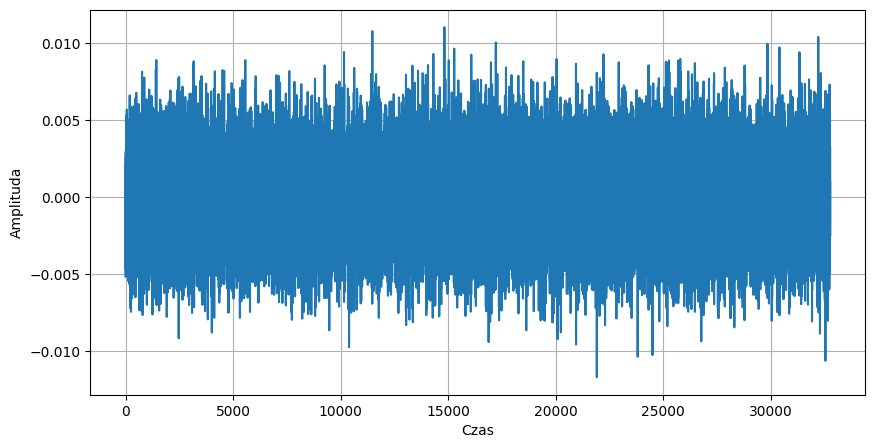

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

frequencies = np.linspace(0.0, 0.5, 10000)
noise = np.abs(np.random.normal(0, 1, len(frequencies))) + 0.001
power_spectrum = (frequencies ** 0.5) * noise

# Wyznaczanie amplitud i losowych faz
amplitudes = np.sqrt(power_spectrum)
phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(frequencies)))
complex_spectrum = amplitudes * phases

# Uzupełnienie do pełnej długości dla FFT
n = int(np.ceil(np.log2(len(frequencies))))
new_size = 2**(n+1)
half_size = len(frequencies)

# Tworzenie symetrycznego widma
full_spectrum = np.zeros(new_size, dtype=np.complex128)
full_spectrum[1:half_size] = complex_spectrum[1:]
full_spectrum[-half_size+1:] = np.conj(complex_spectrum[1:][::-1])

# Odwrotna transformata Fouriera do dziedziny czasu
reconstructed_signal = np.fft.ifft(full_spectrum).real

# Rysowanie widma mocy
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(complex_spectrum)**2, label="Widmo mocy")
plt.title("Sztuczne widmo mocy (beta = -0.5)")
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Rysowanie sygnału w dziedzinie czasu
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, label="sygnał")
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.grid()
plt.show()

rc_025 = reconstructed_signal

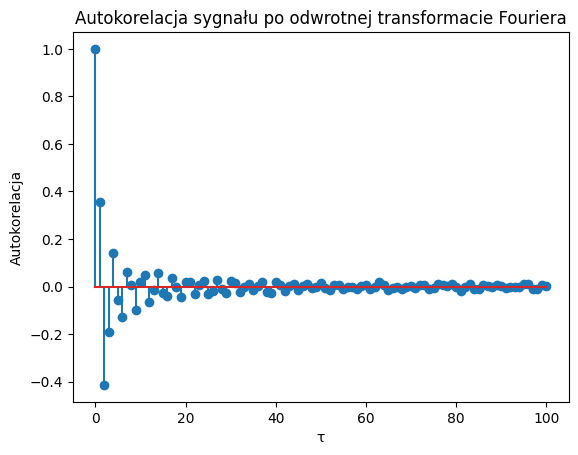

In [ ]:
plt.stem(autocorrelation(reconstructed_signal, 100))
plt.title('Autokorelacja sygnału po odwrotnej transformacie Fouriera')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()

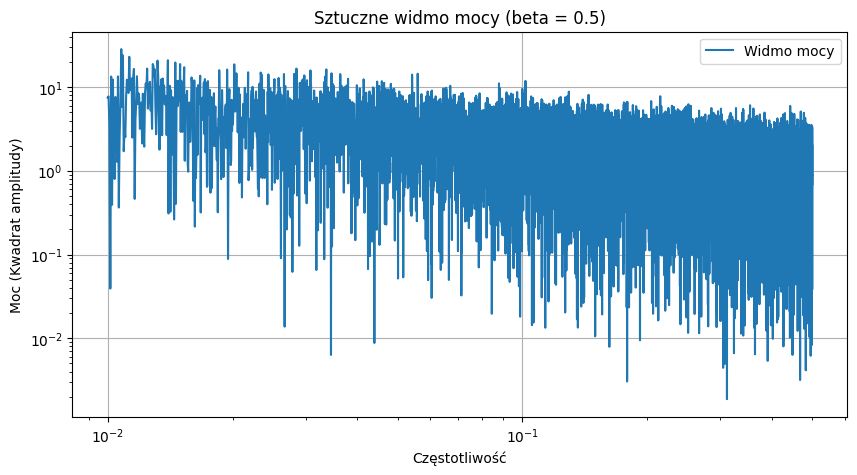

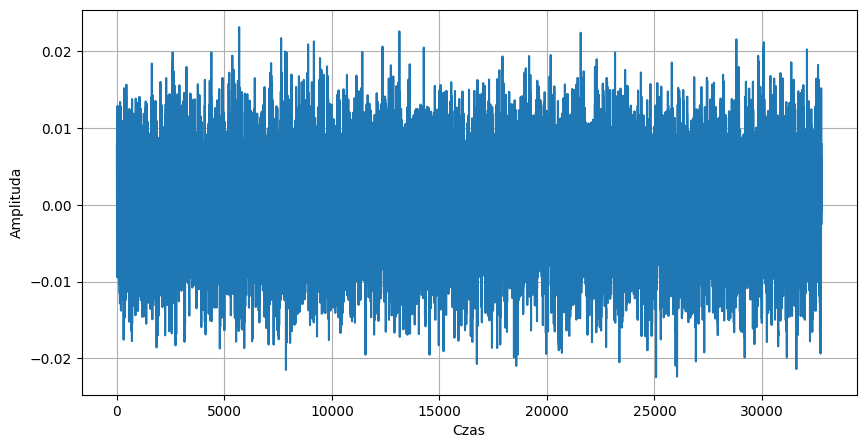

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

frequencies = np.linspace(0.01, 0.5, 10000)
noise = np.abs(np.random.normal(0, 1, len(frequencies))) + 0.001
power_spectrum = (frequencies ** -0.5) * noise

# Wyznaczanie amplitud i losowych faz
amplitudes = np.sqrt(power_spectrum)
phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(frequencies)))
complex_spectrum = amplitudes * phases

# Uzupełnienie do pełnej długości dla FFT
n = int(np.ceil(np.log2(len(frequencies))))
new_size = 2**(n+1)
half_size = len(frequencies)

# Tworzenie symetrycznego widma
full_spectrum = np.zeros(new_size, dtype=np.complex128)
full_spectrum[1:half_size] = complex_spectrum[1:]
full_spectrum[-half_size+1:] = np.conj(complex_spectrum[1:][::-1])

# Odwrotna transformata Fouriera do dziedziny czasu
reconstructed_signal = np.fft.ifft(full_spectrum).real

# Rysowanie widma mocy
plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(complex_spectrum)**2, label="Widmo mocy")
plt.title("Sztuczne widmo mocy (beta = 0.5)")
plt.ylabel('Moc (Kwadrat amplitudy)')
plt.xlabel('Częstotliwość')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Rysowanie sygnału w dziedzinie czasu
plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, label="sygnał")
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.grid()
plt.show()

rc_075 = reconstructed_signal

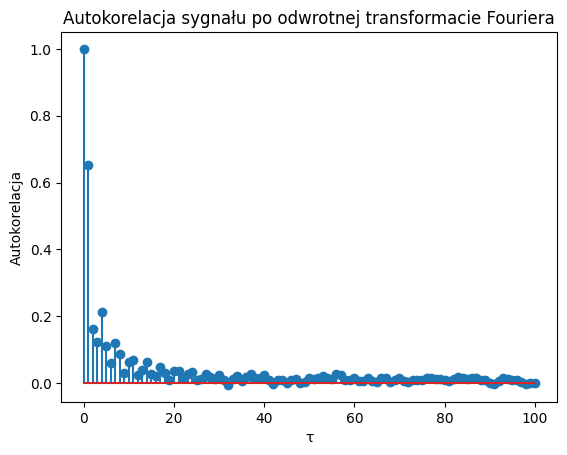

In [ ]:
plt.stem(autocorrelation(reconstructed_signal, 100))
plt.title('Autokorelacja sygnału po odwrotnej transformacie Fouriera')
plt.ylabel('Autokorelacja')
plt.xlabel('τ')
plt.show()